In [2]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import get_provider, Vendors
from bokeh.tile_providers import STAMEN_TONER
import os
import pandas as pd
import geopandas as gpd
from dask.distributed import Client
client = Client(processes = False)
import matplotlib.pyplot as plt
import matplotlib.colors as mocolor

# Set the working directory
wd = '/Users/zxs/Downloads'
os.chdir(wd)

output_notebook()

Loading BokehJS ...

In [3]:
import zipfile

with zipfile.ZipFile('gtfs.zip', 'r') as file:
    
    file.extractall()

os.listdir()

['dallas_crime.csv',
 'nyc.geojson',
 'IBMWatsonStudio.dmg',
 'agency.txt',
 '.DS_Store',
 '.localized',
 'calendar_dates.txt',
 'stop_times.txt',
 'new-york-city-airbnb-open-data.zip',
 'blocks.txt',
 'info.txt',
 'gtfs.zip',
 'dallas_streets.geojson',
 'shapes.txt',
 'trips.txt',
 'feed_info.txt',
 'route_direction.txt',
 'Parcel Shapefile.geojson',
 'img',
 'Cisco_WebEx_Add-On.dmg',
 'nodes.txt',
 'stops.txt',
 'BUD_schedule_fire.png',
 'calendar.txt',
 'AB_NYC_2019.csv',
 'routes.txt',
 'dask-worker-space']

In [4]:
trips = pd.read_csv('trips.txt', low_memory = False)
shapes = pd.read_csv('shapes.txt', low_memory = False)

In [5]:
trips.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
0,20585,2,5764027,2 CULVER,0,201,122462
1,20585,2,5764026,2 CULVER,0,202,122462
2,20585,2,5764025,2 CULVER,0,203,122462
3,20585,2,5764024,2 CULVER,0,201,122462
4,20585,2,5764023,2 CULVER,0,204,122462


In [6]:
shapes.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,122462,32.781561,-96.804166,1,0.0000
1,122462,32.781713,-96.804058,2,0.0197
2,122462,32.781820,-96.804134,3,0.0336
3,122462,32.782023,-96.803918,4,0.0641
4,122462,32.782182,-96.803733,5,0.0889


In [7]:
num_trips_by_shape = trips.groupby('shape_id').aggregate({'route_id': 'count'}).reset_index()
num_trips_by_shape.rename({'route_id': 'trip_count'}, axis='columns', inplace=True)

shapes_with_nums = shapes.merge(num_trips_by_shape, on='shape_id')
shapes_with_nums.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,trip_count
0,122462,32.781561,-96.804166,1,0.0000,89
1,122462,32.781713,-96.804058,2,0.0197,89
2,122462,32.781820,-96.804134,3,0.0336,89
3,122462,32.782023,-96.803918,4,0.0641,89
4,122462,32.782182,-96.803733,5,0.0889,89


In [8]:
from datashader.utils import lnglat_to_meters
import numpy as np

shapes_with_nums['coord_x'], shapes_with_nums['coord_y'] = lnglat_to_meters(shapes_with_nums['shape_pt_lon'], shapes_with_nums['shape_pt_lat'])

def split_df_by(df, byvar):
    df_parts = []
    for level, df_part in df.groupby(byvar):
        empty = pd.DataFrame([[level if colname == byvar else np.NaN for colname in df.columns]],
                             columns=df.columns)
        df_parts.append(df_part.append(empty))
    return pd.concat(df_parts) 

sep_shapes = split_df_by(shapes_with_nums, 'shape_id')

In [9]:
crime = pd.read_csv('dallas_crime.csv', dtype = str)


df = crime.loc[crime['Year of Incident'] == '2019']

df1 = df.loc[df['Year of Incident'] == '2019']

df2 = df1.dropna(subset = ['X Coordinate', 'Y Cordinate'])

df2[['X Coordinate', 'Y Cordinate']] = df2[['X Coordinate', 'Y Cordinate']].apply(lambda x: x.astype(float))

print('There are {} records'.format(len(crime)))

/Users/zxs/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


There are 609217 records


In [30]:
import bokeh.plotting as bp
from bokeh.models.tiles import WMTSTileSource
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bokeh_ext import InteractiveImage
from datashader.utils import export_image
import colorcet as cc

bp.output_notebook()

x_range=(min(sep_shapes['coord_x']), max(sep_shapes['coord_x']))
y_range=(min(sep_shapes['coord_y']), max(sep_shapes['coord_y']))

Loading BokehJS ...

In [31]:
sep_shapes.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,trip_count,coord_x,coord_y
0,122462,32.781561,-96.804166,1.0,0.0000,89.0,-1.077619e+07,3.866346e+06
1,122462,32.781713,-96.804058,2.0,0.0197,89.0,-1.077618e+07,3.866366e+06
2,122462,32.781820,-96.804134,3.0,0.0336,89.0,-1.077619e+07,3.866380e+06
3,122462,32.782023,-96.803918,4.0,0.0641,89.0,-1.077616e+07,3.866407e+06
4,122462,32.782182,-96.803733,5.0,0.0889,89.0,-1.077614e+07,3.866428e+06


In [32]:
p = bp.figure(tools='pan,wheel_zoom,reset',
              plot_width=int(600),
              plot_height=int(600),
              x_range=x_range,
              y_range=y_range)

p.axis.visible = False
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

In [33]:
cvs = ds.Canvas(x_range=x_range, y_range=y_range)
agg = cvs.line(sep_shapes, 'coord_x', 'coord_y', agg=ds.sum('trip_count'))

In [34]:
image = tf.shade(agg, cmap=cc.fire, how='eq_hist')

In [35]:
%%time

# Load building data
dallas = gpd.read_file('dallas_streets.geojson')
dallas.crs = {'init': 'epsg:4326'}
dallas = dallas.set_geometry('geometry')

CPU times: user 12.6 s, sys: 717 ms, total: 13.3 s
Wall time: 13.2 s


[]

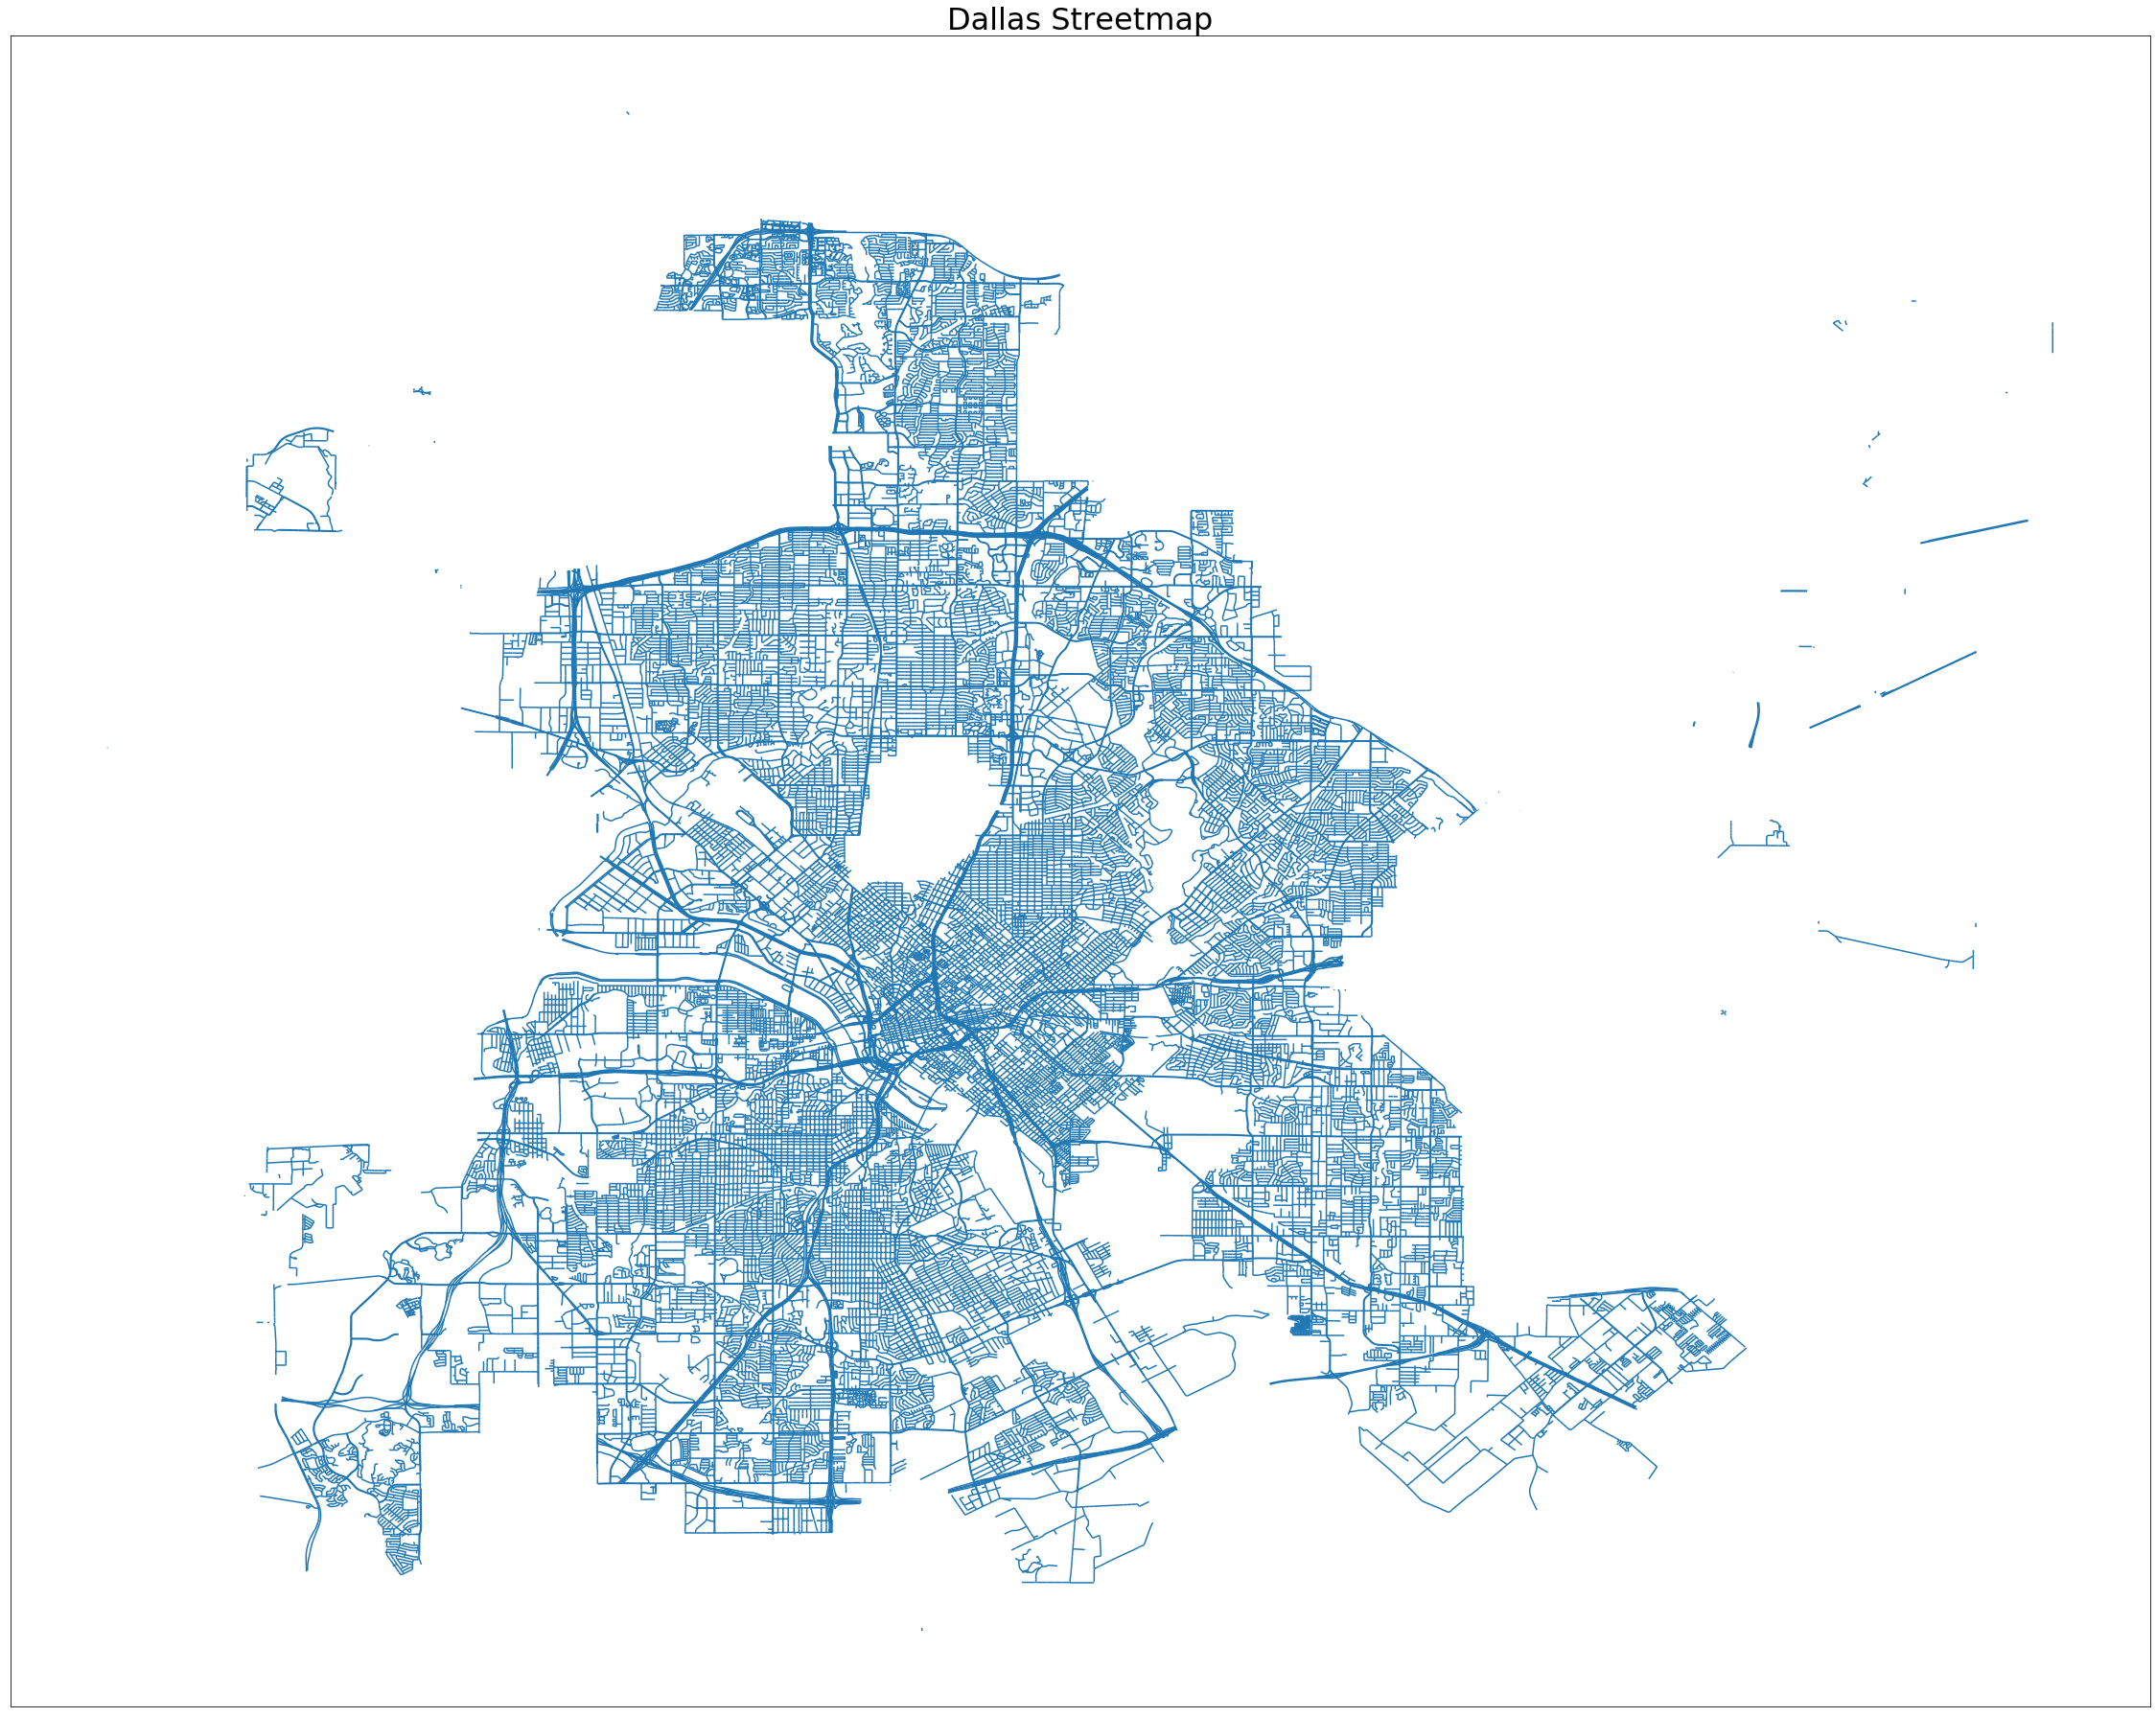

In [36]:
# Visualize using GPD
ax = dallas.plot(figsize = [40, 40])
ax.set_title('Dallas Streetmap', fontsize = 32)
ax.set_xticks([])
ax.set_yticks([])

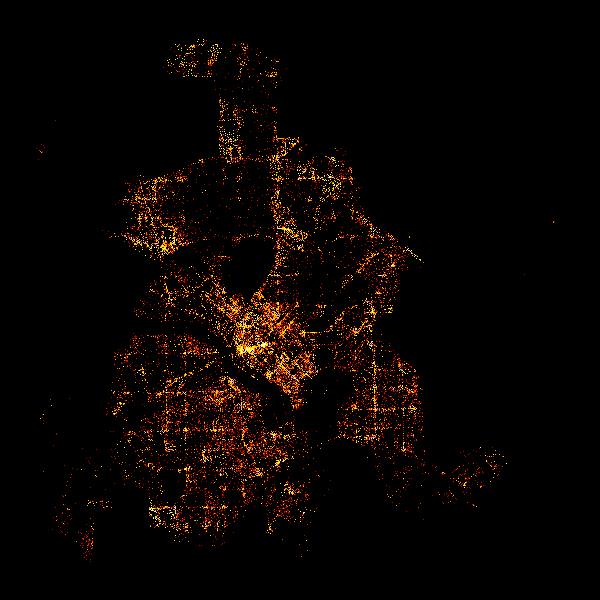

In [37]:
from colorcet import fire
agg = ds.Canvas().points(df2, 'X Coordinate', 'Y Cordinate')
tf.set_background(tf.shade(agg, cmap = fire), 'black')

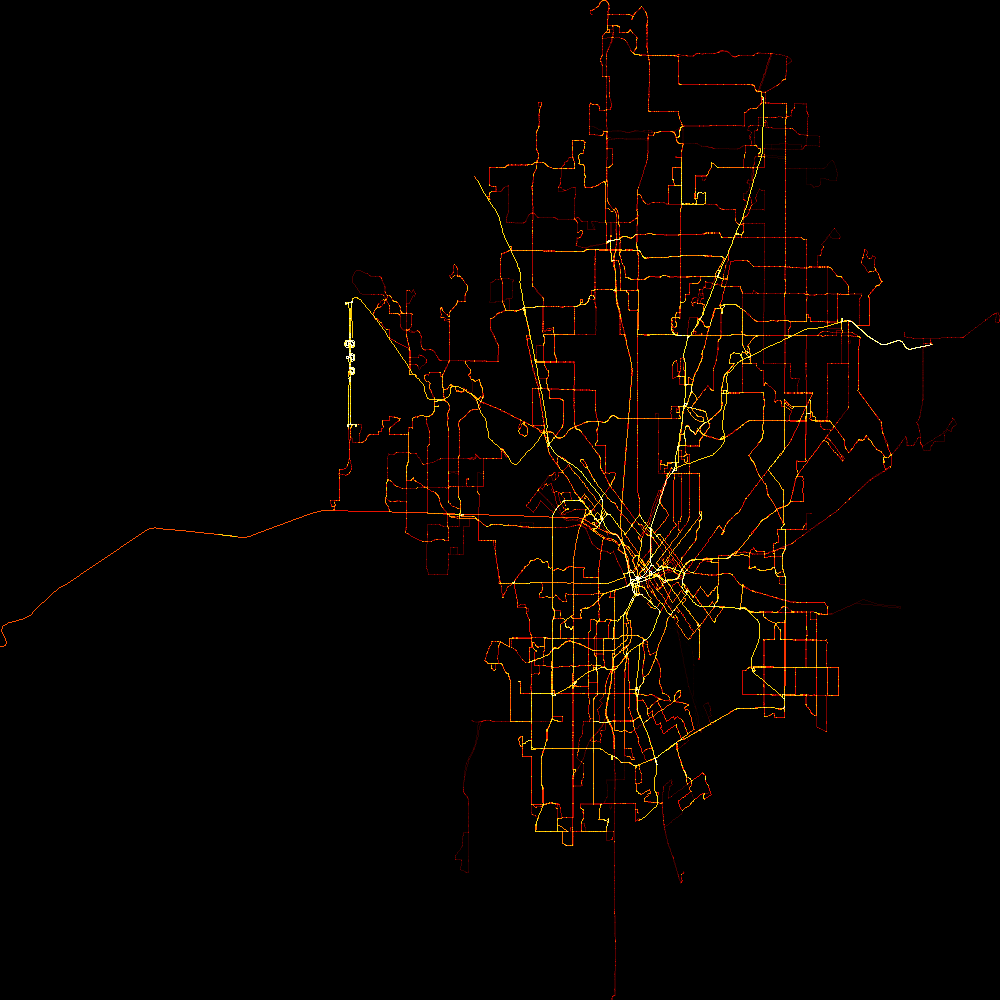

In [38]:
cvs = ds.Canvas(plot_width = 1000, 
                plot_height = 1000, 
                x_range = x_range, 
                y_range = y_range)

agg = cvs.line(sep_shapes, 'coord_x', 'coord_y', agg=ds.sum('trip_count'))
tf.set_background(tf.shade(agg, cmap = fire), 'black')

In [51]:
import geoviews as gv
from bokeh.models import WMTSTileSource
from holoviews.operation.datashader import datashade, dynspread

geourl = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'
geomap = gv.WMTS(geourl)

In [47]:
df2.head()

,Incident Number w/year,Year of Incident,Service Number ID,Watch,Call (911) Problem,Type of Incident,Type Location,Type of Property,Incident Address,Apartment Number,...,NIBRS Code,NIBRS Group,NIBRS Type,Update Date,X Coordinate,Y Cordinate,Zip Code,City,State,Location1
1,063412-2019,2019,063412-2019-01,2,6XA - MAJOR DIST AMBULANCE,ASSAULT -OFFENSIVE CONTACT,NaN,NaN,5631 SPRING VALLEY RD,175,...,13B,A,Coded,2019-04-21 16:30:56.0000000,2.486844e+06,7.028765e+06,75254,DALLAS,TX,"5631 SPRING VALLEY RD\nDALLAS, TX 75254\n(32.9..."
2,012761-2019,2019,012761-2019-01,2,40/01 - OTHER,UNEXPLAINED DEATH (NO OFFENSE),NaN,NaN,3601 CARL ST,NaN,...,999,D,Not Coded,2019-05-02 20:57:59.0000000,2.504558e+06,6.968313e+06,75210,DALLAS,TX,"3601 CARL ST\nDALLAS, TX 75210\n(32.77202, -96..."
3,018074-2019,2019,018074-2019-01,1,40 - OTHER,ASSAULT -VERBAL THREAT,NaN,NaN,4309 MYRTLE ST,NaN,...,13C,A,Coded,2019-03-04 11:22:35.0000000,2.504154e+06,6.962821e+06,75215,DALLAS,TX,"4309 MYRTLE ST\nDALLAS, TX 75215\n(32.757215, ..."
4,050558-2019,2019,050558-2019-01,2,20 - ROBBERY,ROBBERY OF INDIVIDUAL,NaN,NaN,205 S LAMAR ST,NaN,...,120,A,Coded,2019-04-03 12:32:33.0000000,2.489673e+06,6.970467e+06,75202,DALLAS,TX,"205 S LAMAR ST\nDALLAS, TX 75202\n(32.7785, -9..."
9,195552-2019,2019,195552-2019-01,3,6X - MAJOR DIST (VIOLENCE),OTHER OFFENSE - MISDEMEANOR,Convenience Store,Outdoor Area Public/Private,3512 BONNIE VIEW RD,NaN,...,90Z,B,No Coded,2019-09-26 02:33:59.0000000,2.498651e+06,6.947621e+06,75216,DALLAS,TX,"3512 BONNIE VIEW RD\nDALLAS, TX 75216\n(32.715..."


In [62]:
from colorcet import bmw
import holoviews as hv

pts = hv.Points(gv.Dataset(df2, kdims = ['X Coordinate', 'Y Cordinate'], vdims = ['Type of Incident']))
out = dynspread(datashade(pts, color_key = bmw, element_type = gv.Image, aggregator = ds.count()))
geomap * out

:DynamicMap   []

In [63]:
cvs = ds.Canvas(plot_width = 1000, 
                plot_height = 1000, 
                x_range = x_range, 
                y_range = y_range)

agg = cvs.line(sep_shapes, 'coord_x', 'coord_y', agg=ds.sum('trip_count'))
tf.set_background(tf.shade(agg, cmap = fire), geomap)

TypeError: Don't know how to convert :WMTS   [Longitude,Latitude] to RGB